In [120]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gdal
import scipy as sp
#import dask.dataframe

#import cartopy
#import imageio

In [121]:
s_time = datetime(2019,1,1,0)
e_time = datetime(2019,12,31,0)



#Townsville
# location = 'Townsville'
# lat_tv = -19.30
# lon_tv = 146.717

#Brisbane
location = 'Brisbane'
lat_tv =-27.463
lon_tv = 153.026

#Gulf
#lat_tv =  -17.882
#lon_tv =  140.369


#lat0 = -10
#lat1 = -30
#lon0 = 135
#lon1 = 155
res = 0.05

# #Rockhampton 
# location = 'Rockhampton'
# lat_tv=-23.37806
# lon_tv=150.51361

#Cape York
# location = 'Cape York'
# lat_tv=-10.6885038124
# lon_tv=142.5316681914

# A list of locations along the QLD coast:
# Brisbane -27.46778° / 153.02806°
# Bundaberg -24.86611° / 152.34944°
# 
# Mackay -21.14111° / 149.18583°
# Townsville -19.25972° / 146.81694°
# Cairns -16.92194° / 145.77583°
# Cape York -10.6885038124° / 142.5316681914°
# 10:25
# And a few inland ones:
# Charleville -26.40167° / 146.23833°
# Longreach -23.44222° / 144.24917°
# Mount Isa -20.726112° / 139.493896°


In [122]:
# path for HIMAWARI (after running Pablos algorthim to stack nc files)

# path_him = ["" for x in range(12)]

# path_him[0] = '/g/data1a/oe9/user/data/himawari/01/gadi/HIM8_QLD_20190101T0000-20190131T2300.nc'
# path_him[1] =  '/g/data1a/oe9/user/data/himawari/02/gadi/HIM8_QLD_20190201T0000-20190228T2300.nc'
# path_him[2] =  '/g/data1a/oe9/user/data/himawari/03/gadi/HIM8_QLD_20190301T0000-20190331T2300.nc'
# path_him[3] =  '/g/data1a/oe9/user/data/himawari/04/gadi/HIM8_QLD_20190401T0000-20190430T2300.nc'
# path_him[4] =  '/g/data1a/oe9/user/data/himawari/05/gadi/HIM8_QLD_20190501T0000-20190531T2300.nc'
# path_him[5] =  '/g/data1a/oe9/user/data/himawari/06/gadi/HIM8_QLD_20190601T0000-20190630T2300.nc'
# path_him[6] =  '/g/data1a/oe9/user/data/himawari/07/gadi/HIM8_QLD_20190701T0000-20190731T2300.nc'
# path_him[7] =  '/g/data1a/oe9/user/data/himawari/08/gadi/HIM8_QLD_20190801T0000-20190831T2300.nc'
# path_him[8] =  '/g/data1a/oe9/user/data/himawari/09/gadi/HIM8_QLD_20190901T0000-20190930T2300.nc'
# path_him[9] =  '/g/data1a/oe9/user/data/himawari/10/gadi/HIM8_QLD_20191001T0000-20191031T2300.nc'
# path_him[10] =  '/g/data1a/oe9/user/data/himawari/11/gadi/HIM8_QLD_20191101T0000-20191130T2300.nc'
# path_him[11] =  '/g/data1a/oe9/user/data/himawari/12/gadi/HIM8_QLD_20191201T0000-20191231T2300.nc'


path_him = '/g/data1a/oe9/user/data/himawari/HIM8_QLD_20190101T0000-20191231T2300.nc'

path_awap = '/g/data1a/oe9/user/data/gridded_rainfall_0.05deg/rain_day_2019_Actual_day.nc'


In [123]:
him_all = xr.open_dataset(path_him)

him = him_all.sel(lat = lat_tv, lon = lon_tv, method = 'nearest')


In [124]:
#Create individal filters and create a cummulative filter

him['f1'] = (him['B14']<=230)
him['f2'] = (him['B8']-him['B12'])>= -10

him['mask_n'] = him['f1']*1 + him['f2']*1

In [125]:
him['f3'] = (him['B8']-him['B10'])>= -7
him['f4'] = (him['B16']-him['B14'])>= -5

him['mask_n'] = him['mask_n']*1 + him['f3']*1 + him['f4']*1

In [126]:
him['f5'] = (him['B15']-him['B14'])>= -1.5
him['f6'] = (him['B11']-him['B14'])>= 2

him['mask_n'] = him['mask_n']*1 + him['f5']*1 + him['f6']*1

In [127]:
him['f7'] = (((him['B8']+him['B13'])/2)-273) <= -35
him['mask_n'] = him['mask_n'] + him['f7']*1


In [128]:
him['mask']= him['mask_n']>=5

In [129]:
him['mask'].time

<xarray.DataArray 'time' (time: 8178)>
array([20190101.      , 20190101.041667, 20190101.083333, ..., 20191219.666667,
       20191219.708333, 20191219.75    ])
Coordinates:
  * time     (time) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
    lon      float64 153.0
    lat      float64 -27.47
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [130]:

him2 = him.copy()
him2.time.values = np.floor(him2.time.values)

index_time = np.unique(him2.time.values, return_index=True)

him3=him2[['mask']].isel(time = index_time[1]).copy()

lat = him3['lat'].values
lon = him3['lon'].values
time = him3['time'].values


date_convect = np.empty((len(him3.time.values),2))

for ii in np.arange(len(him3.time.values)):
    
    print(ii)
    date_convect[ii,0] = him3.time.values[ii]
    if ii == 271:
            date_convect[ii,1]=0
    else:
        date_convect[ii,1] = np.any(np.stack(him2['mask'].sel(time=him3.time.values[ii]).values),axis = 0)


#index_time
#     if ii==0:
#         mask_all = mask.copy()
#         mask_all = np.expand_dims(mask_all,axis=1)
#         mask_all = np.expand_dims(mask_all,axis=0)
#     else:
#         mask = np.expand_dims( mask,axis=1)
#         mask = np.expand_dims( mask,axis=0)
#         mask_all= np.append( mask_all,mask,axis=0)

        
# Create new xarray object
#him4 = xr.Dataset({'mask': (['time', 'lat', 'lon'],  mask_all)},coords={ 'lon': lon, 'lat': lat, 'time': time})

#print(him4)
#fig, axes = plt.subplots(ncols=2,figsize=(20,10))


#him4['mask'].isel(time=0).plot(ax=axes[0])

#him4['mask'].isel(time=2).plot(ax=axes[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [131]:
#him = xr.open_dataset(path_him)

import pandas as pd

awap= xr.open_dataset(path_awap)
awap = awap.sel(latitude = lat_tv, longitude = lon_tv, method = 'nearest')
awap = awap.sel(time = slice(s_time,e_time))


awap_date = awap.time.data
awap_rain = awap.rain_day.values
awap_date = pd.DatetimeIndex(awap_date)

#awap['rain_day'].sel(time=datetime(2019,1,28,0)).plot(figsize = (8,6))
print(awap_date)
awap_date=(awap_date.year*10000)+awap_date.month*100+awap_date.day
awap_date = awap_date/1
date_convect[:,0]

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=365, freq=None)


array([20190101., 20190102., 20190103., 20190104., 20190105., 20190106.,
       20190107., 20190108., 20190109., 20190110., 20190111., 20190112.,
       20190113., 20190114., 20190115., 20190116., 20190117., 20190118.,
       20190119., 20190120., 20190121., 20190122., 20190123., 20190124.,
       20190125., 20190126., 20190127., 20190128., 20190129., 20190130.,
       20190131., 20190201., 20190202., 20190203., 20190204., 20190205.,
       20190206., 20190207., 20190208., 20190209., 20190210., 20190211.,
       20190212., 20190213., 20190214., 20190215., 20190216., 20190217.,
       20190218., 20190219., 20190220., 20190221., 20190222., 20190223.,
       20190224., 20190225., 20190226., 20190227., 20190228., 20190301.,
       20190302., 20190303., 20190304., 20190305., 20190306., 20190307.,
       20190308., 20190309., 20190310., 20190311., 20190312., 20190313.,
       20190314., 20190315., 20190316., 20190317., 20190318., 20190319.,
       20190320., 20190321., 20190322., 20190323., 

In [132]:
col= np.expand_dims(0* date_convect[:,1],axis=1)

date_convect_rain = np.append(date_convect, col,axis = 1)

print(date_convect_rain.shape)



for ii in np.arange(date_convect_rain.shape[0]):
    filt = (awap_date == date_convect_rain[ii,0])
    
    if np.any(filt)==True:
        date_convect_rain[ii,2] = awap_rain[filt]
    else:
        date_convect_rain[ii,2] = 0
        
date_convect_rain

(351, 3)


array([[2.0190101e+07, 0.0000000e+00, 0.0000000e+00],
       [2.0190102e+07, 0.0000000e+00, 0.0000000e+00],
       [2.0190103e+07, 0.0000000e+00, 2.1015625e+00],
       ...,
       [2.0191217e+07, 0.0000000e+00, 0.0000000e+00],
       [2.0191218e+07, 0.0000000e+00, 0.0000000e+00],
       [2.0191219e+07, 0.0000000e+00, 0.0000000e+00]])

In [133]:
month = date_convect_rain[:,0]-10000*np.floor(date_convect_rain[:,0]/10000)
month = np.expand_dims(np.floor(month/100),axis = 1)
month.shape
date_convect_rain_month = np.append(date_convect_rain,month,axis = 1)
date_convect_rain_month

array([[2.0190101e+07, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.0190102e+07, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.0190103e+07, 0.0000000e+00, 2.1015625e+00, 1.0000000e+00],
       ...,
       [2.0191217e+07, 0.0000000e+00, 0.0000000e+00, 1.2000000e+01],
       [2.0191218e+07, 0.0000000e+00, 0.0000000e+00, 1.2000000e+01],
       [2.0191219e+07, 0.0000000e+00, 0.0000000e+00, 1.2000000e+01]])

In [134]:
N = len(np.unique(date_convect_rain_month[:,3]))

rain_convect_month = 0*np.unique(date_convect_rain_month[:,3])

rain_other_month = 0*np.unique(date_convect_rain_month[:,3])

for ii in np.arange(N):

    filt = (date_convect_rain_month[:,3]==ii+1)
    conv_filt = np.all((filt, date_convect_rain_month[:,1]==1),axis=0)
    non_conv_filt = np.all((filt, date_convect_rain_month[:,1]!=1),axis=0)  

    rain_convect_month[ii] =  date_convect_rain_month[conv_filt,2].sum()
    rain_other_month[ii] =  date_convect_rain_month[non_conv_filt,2].sum()
    

    


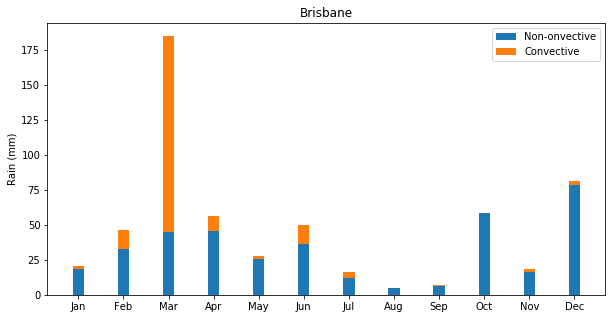

In [135]:
ind = np.arange(N)
width = 0.25

plt.figure(figsize=(10,5))
p1 = plt.bar(ind,rain_other_month,width)
p2 = plt.bar(ind,rain_convect_month,width,bottom = rain_other_month)


# menMeans = (20, 35, 30, 35, 27)
# womenMeans = (25, 32, 34, 20, 25)
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)
# ind = np.arange(N)    # the x locations for the groups
# width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, menMeans, width, yerr=menStd)
# p2 = plt.bar(ind, womenMeans, width,
#              bottom=menMeans, yerr=womenStd)

month_lab = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.ylabel('Rain (mm)')
plt.title(location)
plt.xticks(ind, month_lab[0:(N)])
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Non-onvective', 'Convective'))

filn = 'monthly_rain_2019_'+location+'.png'
plt.savefig(filn)

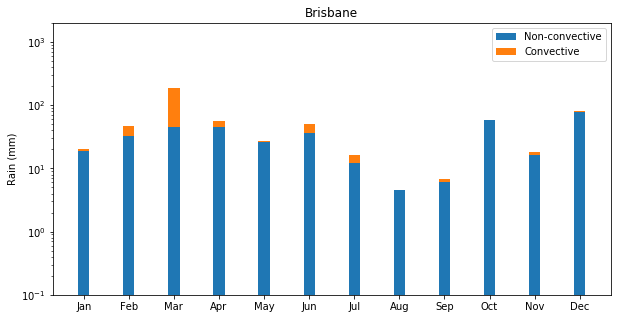

In [136]:
    
ind = np.arange(N)
width = 0.25

plt.figure(figsize=(10,5))
p1 = plt.bar(ind,rain_other_month,width,log=True)
p2 = plt.bar(ind,rain_convect_month,width,bottom = rain_other_month,log=True)

# menMeans = (20, 35, 30, 35, 27)
# womenMeans = (25, 32, 34, 20, 25)
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)
# ind = np.arange(N)    # the x locations for the groups
# width = 0.35       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, menMeans, width, yerr=menStd)
# p2 = plt.bar(ind, womenMeans, width,
#              bottom=menMeans, yerr=womenStd)

month_lab = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.ylabel('Rain (mm)')
plt.title(location)
plt.xticks(ind, month_lab[0:(N)])
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ( 'Non-convective','Convective'))
plt.ylim((0.1,2000))
# plt.show()
filn = 'monthly_rain_2019_'+location+'_log.png'
plt.savefig(filn)